## AS - TP3 - Non-linéarité

http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html

Construction du jeu de données artificiel binaire de 4 gaussiennes, problème du XOR.
Avec deux étiquettes centrées positivement (-1,-1),(1,1) et deux étiquettes négativement centréees (-1,1),(1,-1)

X_train, Y_train : Données d'entrainement & X_test,Y_test : Données de test

In [55]:

 require 'nn'
 require 'gnuplot'
 require 'svm'
 require 'optim'
 require 'nngraph'
 require 'image'
 require 'tools'

 --Fonction prise dans le guide.lua
 function gen_gauss(nbpoints,mu,sigma)
 local d = #mu
 local X = torch.randn(nbpoints,d)
 for i = 1,d do X[{{},i}]=X[{{},i}]*sigma[i]+mu[i] end
 return X
 end

 --Creation de données pour quatres gausiennes
 function create_data(parametres,nbpoints)
     local X_final=gen_gauss(nbpoints,parametres[1][1],parametres[1][2])
     local Y_final=torch.ones(nbpoints,1)
     Y_final=Y_final*parametres[1][3]
     for i=2,4 do
     X_final=torch.cat(X_final,(gen_gauss(nbpoints,parametres[i][1],parametres[i][2])),1)
     Y_final=torch.cat(Y_final,(torch.ones(nbpoints) *parametres[i][3]),1)
     end
     return X_final,Y_final
 end


 -- Paramètres des quatres gaussiennes {mu,sigma,label {-1,1}}
 parametres = {{{1,1},{0.5,0.5},1},
              {{-1,1},{0.5,0.5},-1},
              {{-1,-1},{0.5,0.5},1},
              {{1,-1},{0.5,0.5},-1}}

 -- Création de données pour le train & le test 600 points pour le train, 200 pour le test (ratior=75%/25%)
 x_train,y_train = create_data(parametres,150)
 x_test,y_test=create_data(parametres,50)



In [56]:
function plot_points(xs,ys)  
  local nb_positive=ys:eq(1):sum()
  local nb_negative=ys:eq(-1):sum()
  local xs_positive=torch.Tensor(nb_positive,2)
  local xs_negative=torch.Tensor(nb_negative,2)
  local pos_positive=1
  local pos_negative=1
  for i=1,xs:size(1) do
    if (ys[i]==1) then xs_positive[pos_positive]:copy(xs[i]); pos_positive=pos_positive+1 
                   else xs_negative[pos_negative]:copy(xs[i]); pos_negative=pos_negative+1 end
  end
  
  return {{xs_positive:t()[1],xs_positive:t()[2],"with points"},{xs_negative:t()[1],xs_negative:t()[2],"with points"}}
end

function plot_model(model,x_min,x_max,y_min,y_max,step)
  local all_points={}
  local pos=1
    
  local p=torch.Tensor(2)
  for x=x_min,x_max,step do
    p[1]=x; p[2]=y_min; local v=model:forward(p)[1]
    if (v<0) then v=-1 else v=1 end
    for y=y_min+step,y_max,step do
      p[2]=y
      local val=model:forward(p)[1]
      if (val*v<=0) then 
        v=-v
        all_points[pos]={x,y}
        pos=pos+1
      end
    end
  end
  
  for y=y_min,y_max,step do
    p[1]=x_min; p[2]=y; local v=model:forward(p)[1]
    if (v<0) then v=-1 else v=1 end
    for x=x_min+step,x_max,step do
      p[1]=x
      local val=model:forward(p)[1]
      if (val*v<0) then 
        v=-v
        all_points[pos]={x,y}
        pos=pos+1
      end
    end
  end  
  
  local t=torch.Tensor(all_points)
  if (t:size(1)>0) then return {t:t()[1],t:t()[2],"with points"} end
end
 
function plot(xs,ys,model,precision)
  assert(xs:size(2)==2,"Dimension must be 2 for plotting")
  if (precision==nil) then precision=100 end
  local p1=plot_points(xs,ys,nil)
  local p2=plot_model(model,xs:t()[1]:min(),xs:t()[1]:max(),xs:t()[2]:min(),xs:t()[2]:max(),(xs:t()[1]:max()-xs:t()[1]:min())/precision)
  gnuplot.plot(p2,unpack(p1))
end
  


In [61]:
--gnuplot.plot(plot_points(x_train,y_train))

#### Création d'un réseau de neurone à la "main"
Les différentes couches : Linear(2,5)-->Tanh()-->Linear(5,1)-->Tanh()
Ci-dessous le dessin 

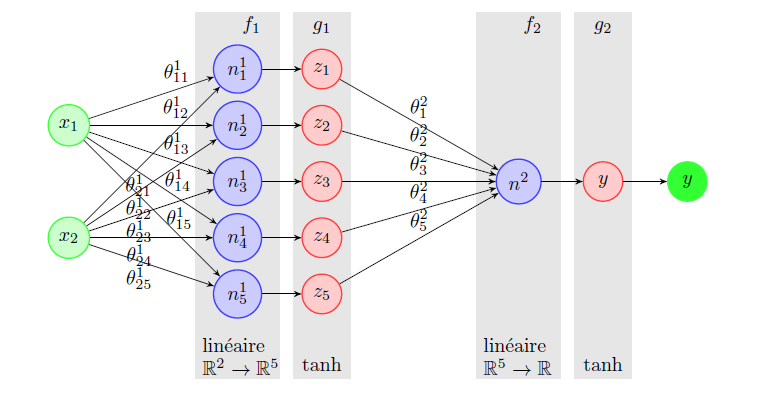

In [67]:
itorch.image('graphic.jpg')

In [64]:
---------------------------------------------
 --------------NO VECTOR ACCURACY-------------
 ---------------------------------------------


function Accuracy_vect(y,out)
    cumul=torch.cmul(torch.sign(y),torch.sign(out))
    acc=torch.mean(cumul)
    return acc
end

--------------------------------------------
--------------TESTING ----------------------
--------------------------------------------

function Eval(xtest,ytest)
    output = model_1:forward(xtest)
    output_1=tan_h1:forward(output)
    output_2=model_2:forward(output_1)
    output_3=tan_h2:forward(output_2)
    return Accuracy_vect(ytest,output_3)
end

 ---------------------------------------------
 -------------- TRAINNING  -------------------
 ---------------------------------------------
N=5
criterion=nn.MSECriterion()

model_1=nn.Linear(2,N)
tan_h1=nn.Tanh()
model_2=nn.Linear(N,1)
tan_h2=nn.Tanh()


nbIter = 1000
lr = 0.001
all_losses={}
compt=0
all_Eval={}

for iteration = 1, nbIter do
  acc=Eval(x_test,y_test)
  table.insert(all_Eval,acc)
  for i=1,x_train:size(1) do
    j=math.random(x_train:size(1))
    --Model init Gradient
    model_1:zeroGradParameters()
    model_2:zeroGradParameters()

    --Forward partie
    O1=model_1:forward(x_train[j])
    O2=tan_h1:forward(O1)
    O3=model_2:forward(O2)
    O4=tan_h2:forward(O3)
    loss=criterion:forward(O4,y_train[j])
    --Backward partie
    delta=criterion:backward(O4,y_train[j])
    delta_4=tan_h2:backward(O3,delta)
    delta_3=model_2:backward(O2,delta_4)
    delta_2=tan_h1:backward(O1,delta_3)
    delta_1=model_1:backward(x_train[j],delta_2)

    model_1:updateParameters(lr)
    model_2:updateParameters(lr)

  end
  if (iteration%100==0) then
    print('accuracy : ' , acc)
  end
  
  table.insert(all_losses,loss)
  --gnuplot.plot(torch.Tensor(all_Eval))
  --gnuplot.plot(torch.Tensor(all_losses))

end



accuracy : 	0.9	


accuracy : 	0.9	


accuracy : 	0.89	


accuracy : 	0.89	


accuracy : 	0.88	


accuracy : 	0.89	


accuracy : 	0.92	


accuracy : 	0.9	


accuracy : 	0.9	


accuracy : 	0.88	


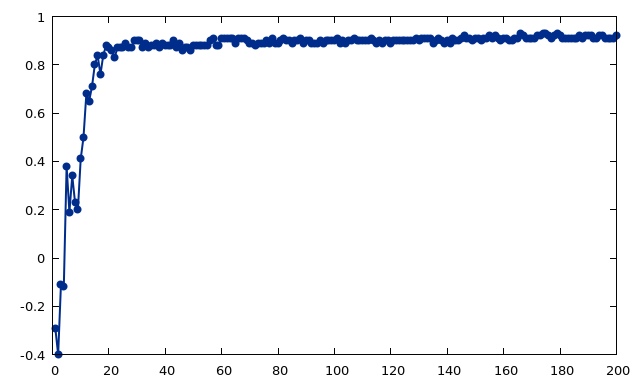

In [65]:
itorch.image('acc_xor1')

#### Passage à la manière Séquentielle : 

In [48]:


 ---------------------------------------------
  --------------NO VECTOR ACCURACY-------------
  ---------------------------------------------


 function Accuracy_vect(y,out)
     cumul=torch.cmul(torch.sign(y),torch.sign(out))
     acc=torch.mean(cumul)
     return acc
 end

 --------------------------------------------
 --------------TESTING ----------------------
 --------------------------------------------

 function Eval(xtest,ytest)
     output = model_Seq:forward(xtest)
     return Accuracy_vect(ytest,output)
 end


model_Seq=nn.Sequential()
model_Seq:add(nn.Linear(2,5))
model_Seq:add(nn.Tanh())
model_Seq:add(nn.Linear(5,1))
criterion=nn.MSECriterion()
lr=0.001
maxEpoch=1000
local all_losses={}
local all_Eval={}


for iteration=1,maxEpoch do
    acc=Eval(x_test,y_test)
    table.insert(all_Eval,acc)

    for i=1,x_train:size(1) do
        j=math.random(x_train:size(1))
        model_Seq:zeroGradParameters()
        output_Seq= model_Seq:forward(x_train[j])
        loss = criterion:forward(output_Seq,y_train[j])

        delta = criterion:backward(output_Seq,y_train[j])
        model_Seq:backward(x_train[j], delta)
        model_Seq:updateParameters(lr)
    end
    table.insert(all_losses,loss)
    --plot(x_train,y_train,model_Seq,100)
    if (iteration%100==0) then
      print('accuracy : ' , acc)
    end
    --gnuplot.plot('eval acc',torch.Tensor(all_Eval))
end


accuracy : 	0.79	


accuracy : 	0.76	


accuracy : 	0.77	


accuracy : 	0.77	


accuracy : 	0.78	


accuracy : 	0.77	


accuracy : 	0.78	


accuracy : 	0.77	


accuracy : 	0.8	


accuracy : 	0.8	


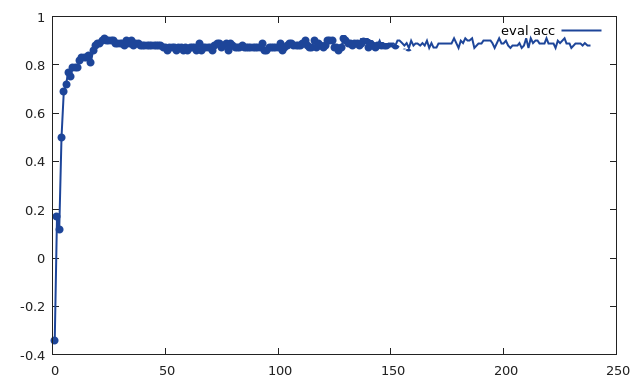

In [53]:
itorch.image('acc_xor')


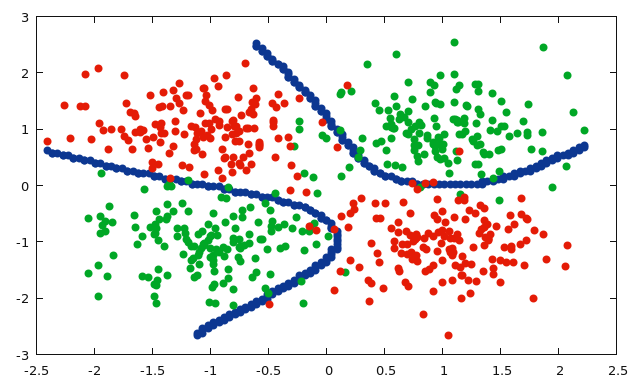

In [54]:
itorch.image('frontiere_seq')